In [55]:
using Revise
using DiffEqCallbacks
using QuantumOptics
using IonSim
using HDF5
using LsqFit
import PyPlot
const plt = PyPlot
const pc = IonSim.PhysicalConstants
using PyCall
using LaTeXStrings
using Statistics
using StochasticDiffEq
qutip = pyimport("qutip")
include("single_ion_vaet_helper_functions.jl");

In [2]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)
plt.matplotlib.rc("text", usetex=false)

# Ideal

In [3]:
h3_nvd = siv_three_lasers(Δ=0, κ=0)
h3_nv = siv_three_lasers(κ=0)
h3 = siv_three_lasers()
h4 = siv_four_lasers();

In [4]:
com = single_mode_chain.vibrational_modes.z[1]
X̂ = create(com.basis) + destroy(com.basis)
fout(t, ψ) = expect(dm(C["S-1/2"]) ⊗ one(com.basis), ψ), expect(one(C.basis) ⊗ X̂, ψ)
fouti(t, ψ) = expect(dm(C["S-1/2"]) ⊗ one(com.basis), ψ);

In [5]:
tspan = collect(0:1:4000)
sol3_nvd = rotated_solve(tspan, h3_nvd, fout=fout)
sol3_nv = rotated_solve(tspan, h3_nv, fout=fout)
sol3 = rotated_solve(tspan, h3, fout=fout)
sol4 = rotated_solve(tspan, h4, fout=fout)
sol3_ideal = rotated_solve(tspan, h3)
dm_sol3_ideal = dm.(sol3_ideal)
sol4_ideal = rotated_solve(tspan, h4)
dm_sol4_ideal = dm.(sol4_ideal);

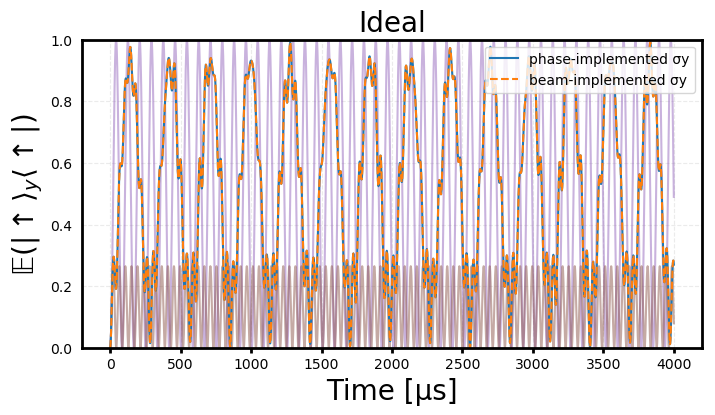

In [6]:
plt.plot(tspan, map(x->x[1], sol3_nvd), color="C4", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3_nv), color="C5", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3), label="phase-implemented σy", color="C0")
plt.plot(tspan, map(x->x[1], sol4), ls="--", label="beam-implemented σy", color="C1")
plt.ylim(0, 1)
plt.xlabel("Time [μs]")
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlim(tspan[1], tspan[end ÷ 1])
plt.legend(loc=1)
plt.title("Ideal")
plt.show()

# B-field noise

In [261]:
Avg_sol3_fid = []
# Avg_sol4_fid = []
N = 250
rdt = 25e-3:-5e-5:5e-4
for decay_time in rdt
    sol3 = 0
    sol4 = 0
    δB = √2 / (dB * decay_time)
    for i in 1:N
        ddb = δB * randn()
        h3 = siv_three_lasers(δB=ddb)
#         h4 = siv_four_lasers(δB=ddb)
        sol3 ≡ 0 ? sol3 = dm.(rotated_solve(tspan, h3)) : sol3 .+= dm.(rotated_solve(tspan, h3))
#         sol4 ≡ 0 ? sol4 = dm.(rotated_solve(tspan, h4)) : sol4 .+= dm.(rotated_solve(tspan, h4))
    end
    push!(Avg_sol3_fid, tracedistance.(sol3 ./ N, dm_sol3_ideal))
#     push!(Avg_sol4_fid, tracedistance.(sol4 ./ N, dm_sol4_ideal))
end

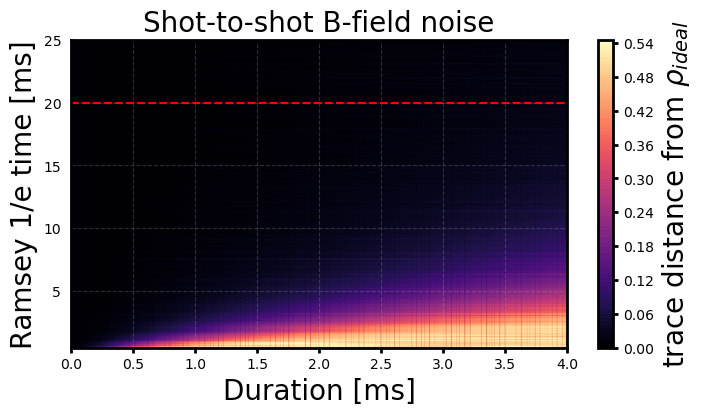

PyObject Text(0.5, 1.0, 'Shot-to-shot B-field noise')

In [267]:
plt.contourf(tspan .* 1e-3, rdt .* 1e3, reduce(hcat, Avg_sol3_fid)', fill=true, cmap="magma", levels=100)
# plt.plot(rdt .* 1e3, rdt .* 1e3, color="white", lw=3, ls="--")
plt.axhline(y=20, color="red", ls="--")
plt.colorbar(label=L"trace distance from $ρ_{ideal}$")
plt.xlim(tspan[1] * 1e-3, tspan[end] * 1e-3)
plt.xlabel("Duration [ms]")
plt.ylabel("Ramsey 1/e time [ms]")
# plt.xlim(0.5, 4)
# plt.ylim(0.5, 4)
plt.title("Shot-to-shot B-field noise")

In [254]:
te1 = 3.5
te2 = 1.8
α = 5
t1 = 2sqrt((α^2 - 1) / (α^2/te2^2 - 1/te1^2) ); print(t1, "\n")
t2 = sqrt( te1^2 / (1 - te1^2/t1^2) ); print(t2, "\n")
te1a = sqrt(t1^2 * t2^2 / (t1^2 + t2^2)); print(te1a)

3.5460731098655502
21.783035203226557
3.5

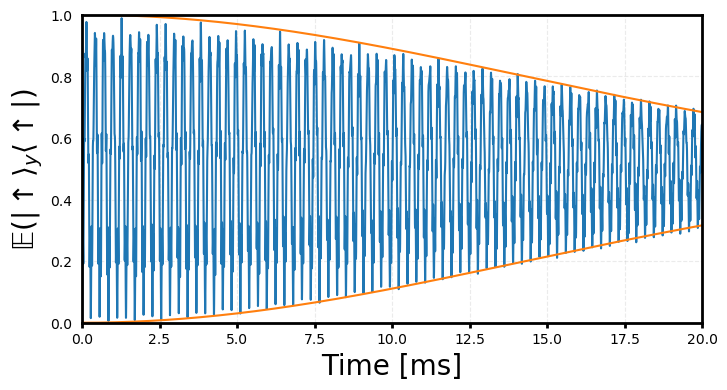

(0.0, 20.0)

In [274]:
decay_time = 20e-3
N = 250
tspan = collect(0:2:20000)
sol3 = 0
sol4 = 0

for i in 1:N
    δB = √2 / (dB * decay_time)
    ddb = δB * randn()
    h3 = siv_three_lasers(δB=ddb)
    h4 = siv_four_lasers(δB=ddb)
    sol3 ≡ 0 ? sol3 = dm.(rotated_solve(tspan, h3)) : sol3 .+= dm.(rotated_solve(tspan, h3))
    sol4 ≡ 0 ? sol4 = dm.(rotated_solve(tspan, h4)) : sol4 .+= dm.(rotated_solve(tspan, h4))
end
plt.plot(tspan .* 1e-3, expect(dm(C["S-1/2"]) ⊗ one(com.basis), sol3 ./ N))
ideal = expect(dm(C["S-1/2"]) ⊗ one(com.basis), sol3_ideal)
plt.plot(tspan.* 1e-3, gaussian_decay.(tspan .* 1e-6, dB * δB), color="C1")
plt.plot(tspan.* 1e-3, 1 .- gaussian_decay.(tspan .* 1e-6, dB * δB), color="C1")
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlabel("Time [ms]")
plt.ylim(0, 1)
plt.xlim(tspan[1] * 1e-3, tspan[end] * 1e-3)

# Intensity Noise

In [291]:
tspan = collect(0:1:4000)
Avg_sol3_fidI = []
Avg_sol4_fidI = []
Avg_sol3_fidI_uncorr = []
Avg_sol4_fidI_uncorr = []
N = 250
rfs = range(1e-4, stop=0.1, length=50)
for rel in rfs
    sol3 = 0
    sol4 = 0
    sol3_uncorr = 0
    sol4_uncorr = 0
    for i in 1:N
        δJ = (1/2) * rel
        h3 = siv_three_lasers(δJ=δJ)
        h4 = siv_four_lasers(δJ=δJ)
        h3_uncorr = siv_three_lasers(δJ=δJ, correlated=false)
        h4_uncorr = siv_four_lasers(δJ=δJ, correlated=false)
        sol3 ≡ 0 ? sol3 = dm.(rotated_solve(tspan, h3)) : sol3 .+= dm.(rotated_solve(tspan, h3))
        sol4 ≡ 0 ? sol4 = dm.(rotated_solve(tspan, h4)) : sol4 .+= dm.(rotated_solve(tspan, h4))
        sol3_uncorr ≡ 0 ? sol3_uncorr = dm.(rotated_solve(tspan, h3_uncorr)) : sol3_uncorr .+= dm.(rotated_solve(tspan, h3_uncorr))
        sol4_uncorr ≡ 0 ? sol4_uncorr = dm.(rotated_solve(tspan, h4_uncorr)) : sol4_uncorr .+= dm.(rotated_solve(tspan, h4_uncorr))
    end
    push!(Avg_sol3_fidI, tracedistance.(sol3 ./ N, dm_sol3_ideal))
    push!(Avg_sol4_fidI, tracedistance.(sol4 ./ N, dm_sol4_ideal))
    push!(Avg_sol3_fidI_uncorr, tracedistance.(sol3_uncorr ./ N, dm_sol3_ideal))
    push!(Avg_sol4_fidI_uncorr, tracedistance.(sol4_uncorr ./ N, dm_sol4_ideal))
end

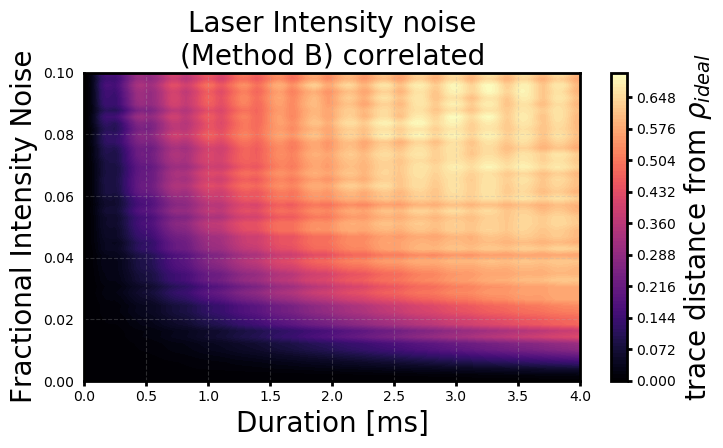

PyObject Text(0.5, 1.0, 'Laser Intensity noise\n(Method B) correlated')

In [292]:
plt.contourf(tspan .* 1e-3, rfs, reduce(hcat, Avg_sol3_fidI)', fill=true, cmap="magma", levels=100)
plt.axhline(y=0.01, color="red", ls="--")
plt.colorbar(label=L"trace distance from $ρ_{ideal}$")
plt.xlim(tspan[1] * 1e-3, tspan[end] * 1e-3)
plt.xlabel("Duration [ms]")
plt.ylabel("Fractional Intensity Noise")
# plt.xlim(0.5, 4)
# plt.ylim(0.5, 4)
plt.title("Laser Intensity noise\n(Method B) correlated")

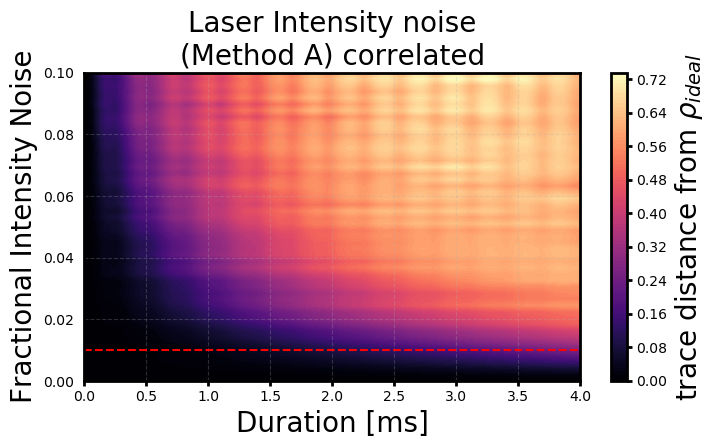

PyObject Text(0.5, 1.0, 'Laser Intensity noise\n(Method A) correlated')

In [340]:
plt.contourf(tspan .* 1e-3, rfs, reduce(hcat, Avg_sol4_fidI)', fill=true, cmap="magma", levels=100)
plt.axhline(y=0.01, color="red", ls="--")
plt.colorbar(label=L"trace distance from $ρ_{ideal}$")
plt.xlim(tspan[1] * 1e-3, tspan[end] * 1e-3)
plt.xlabel("Duration [ms]")
plt.ylabel("Fractional Intensity Noise")
# plt.xlim(0.5, 4)
# plt.ylim(0.5, 4)
plt.title("Laser Intensity noise\n(Method A) correlated")

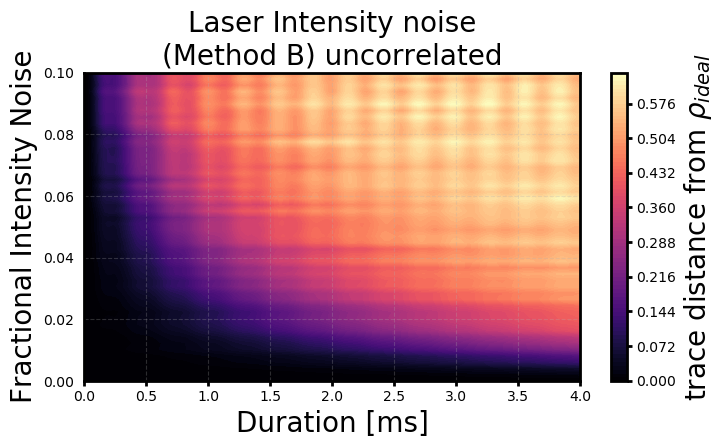

PyObject Text(0.5, 1.0, 'Laser Intensity noise\n(Method B) uncorrelated')

In [296]:
plt.contourf(tspan .* 1e-3, rfs, reduce(hcat, Avg_sol3_fidI_uncorr)', fill=true, cmap="magma", levels=100)
plt.axhline(y=0.01, color="red", ls="--")
plt.colorbar(label=L"trace distance from $ρ_{ideal}$")
plt.xlim(tspan[1] * 1e-3, tspan[end] * 1e-3)
plt.xlabel("Duration [ms]")
plt.ylabel("Fractional Intensity Noise")
# plt.xlim(0.5, 4)
# plt.ylim(0.5, 4)
plt.title("Laser Intensity noise\n(Method B) uncorrelated")

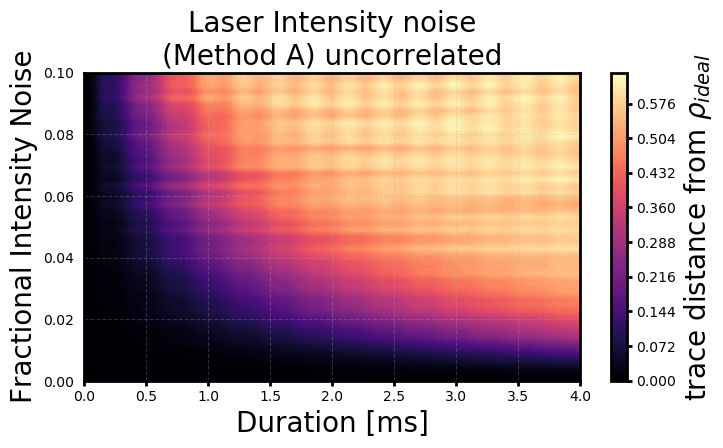

PyObject Text(0.5, 1.0, 'Laser Intensity noise\n(Method A) uncorrelated')

In [302]:
plt.contourf(tspan .* 1e-3, rfs, reduce(hcat, Avg_sol4_fidI_uncorr)', fill=true, cmap="magma", levels=100)
plt.axhline(y=0.01, color="red", ls="--")
plt.colorbar(label=L"trace distance from $ρ_{ideal}$")
plt.xlim(tspan[1] * 1e-3, tspan[end] * 1e-3)
plt.xlabel("Duration [ms]")
plt.ylabel("Fractional Intensity Noise")
# plt.xlim(0.5, 4)
# plt.ylim(0.5, 4)
plt.title("Laser Intensity noise\n(Method A) uncorrelated")

In [367]:
rel = 0.01
N = 250
tspan = collect(0:2:10000)
sol3 = 0
sol3_nv = 0
sol3_nvd = 0
# sol4 = 0
# sol3_uncorr = 0
# sol4_uncorr = 0
for i in 1:N
    δJ = rel / 2 
    h3 = siv_three_lasers(δJ=δJ)
    h3_nv = siv_three_lasers(δJ=δJ, κ=0)
    h3_nvd = siv_three_lasers(δJ=δJ, κ=0, Δ=0)
#     h4 = siv_four_lasers(δJ=δJ)
#     h3_uncorr = siv_three_lasers(δJ=δJ, correlated=false)
#     h4_uncorr = siv_four_lasers(δJ=δJ, correlated=false)
    sol3 ≡ 0 ? sol3 = dm.(rotated_solve(tspan, h3)) : sol3 .+= dm.(rotated_solve(tspan, h3))
#     sol4 ≡ 0 ? sol4 = dm.(rotated_solve(tspan, h4)) : sol4 .+= dm.(rotated_solve(tspan, h4))
#     sol3_uncorr ≡ 0 ? sol3_uncorr = dm.(rotated_solve(tspan, h3_uncorr)) : sol3_uncorr .+= dm.(rotated_solve(tspan, h3_uncorr))
#     sol4_uncorr ≡ 0 ? sol4_uncorr = dm.(rotated_solve(tspan, h4_uncorr)) : sol4_uncorr .+= dm.(rotated_solve(tspan, h4_uncorr))
    sol3_nv ≡ 0 ? sol3_nv = dm.(rotated_solve(tspan, h3_nv)) : sol3_nv .+= dm.(rotated_solve(tspan, h3_nv))
    sol3_nvd ≡ 0 ? sol3_nvd = dm.(rotated_solve(tspan, h3_nvd)) : sol3_nvd .+= dm.(rotated_solve(tspan, h3_nvd))
end

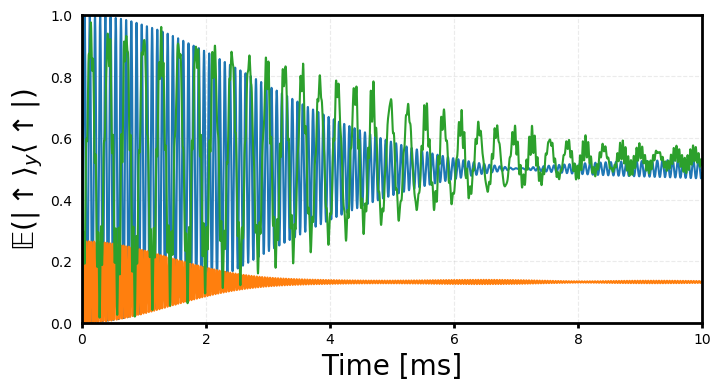

(0.0, 10.0)

In [373]:
plt.plot(tspan .* 1e-3, expect(dm(C["S-1/2"]) ⊗ one(com.basis), sol3_nvd ./ N))
plt.plot(tspan .* 1e-3, expect(dm(C["S-1/2"]) ⊗ one(com.basis), sol3_nv ./ N))
plt.plot(tspan .* 1e-3, expect(dm(C["S-1/2"]) ⊗ one(com.basis), sol3 ./ N))
ideal = expect(dm(C["S-1/2"]) ⊗ one(com.basis), sol3_ideal)
# plt.plot(tspan.* 1e-3, 0.99 .* gaussian_decay.(tspan .* 1e-6, 250), color="C1")
# plt.plot(tspan.* 1e-3, 1 .- 0.99 .* gaussian_decay.(tspan .* 1e-6, 250), color="C1")
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlabel("Time [ms]")
plt.ylim(0, 1)
plt.xlim(tspan[1] * 1e-3, tspan[end] * 1e-3)
# plt.xlim(0, 4)

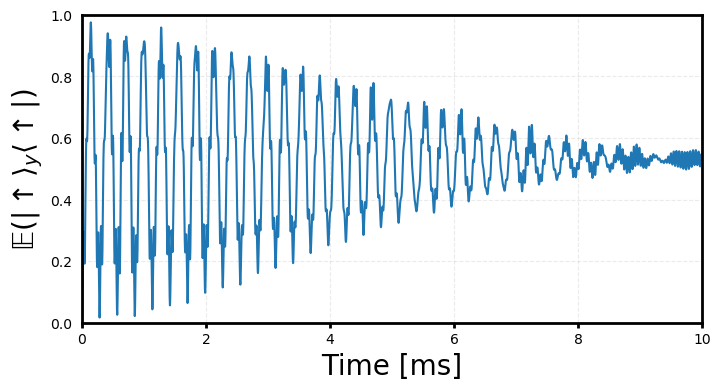

(0.0, 10.0)

In [372]:
plt.plot(tspan .* 1e-3, expect(dm(C["S-1/2"]) ⊗ one(com.basis), sol4 ./ N))
ideal = expect(dm(C["S-1/2"]) ⊗ one(com.basis), sol3_ideal)
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlabel("Time [ms]")
plt.ylim(0, 1)
plt.xlim(tspan[1] * 1e-3, tspan[end] * 1e-3)
# plt.xlim(0, 4)

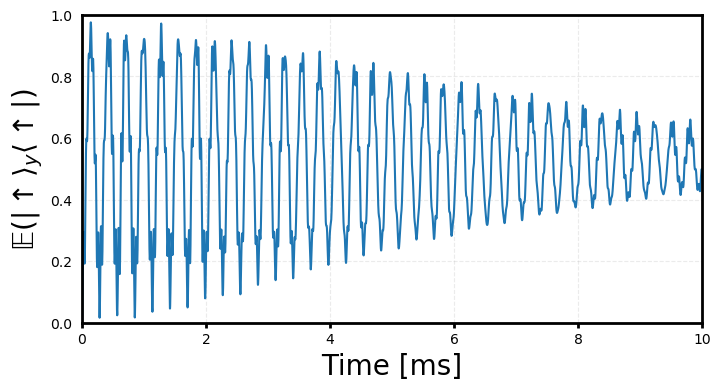

(0.0, 10.0)

In [370]:
plt.plot(tspan .* 1e-3, expect(dm(C["S-1/2"]) ⊗ one(com.basis), sol3_uncorr ./ N))
ideal = expect(dm(C["S-1/2"]) ⊗ one(com.basis), sol3_ideal)
# plt.plot(tspan.* 1e-3, gaussian_decay.(tspan .* 1e-6, 250), color="C1")
# plt.plot(tspan.* 1e-3, 1 .- gaussian_decay.(tspan .* 1e-6, 250), color="C1")
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlabel("Time [ms]")
plt.ylim(0, 1)
plt.xlim(tspan[1] * 1e-3, tspan[end] * 1e-3)
# plt.xlim(0, 4)

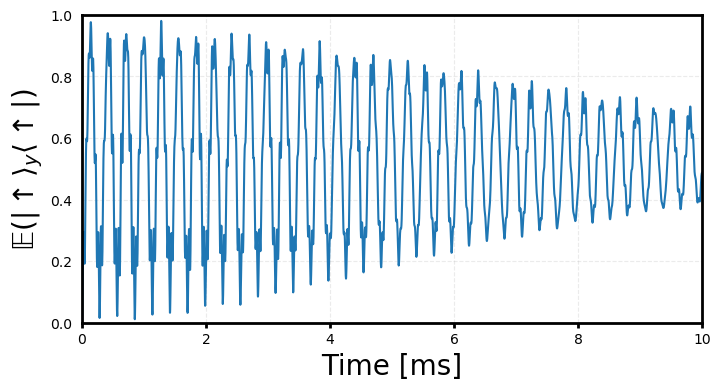

(0.0, 10.0)

In [371]:
plt.plot(tspan .* 1e-3, expect(dm(C["S-1/2"]) ⊗ one(com.basis), sol4_uncorr ./ N))
ideal = expect(dm(C["S-1/2"]) ⊗ one(com.basis), sol3_ideal)
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlabel("Time [ms]")
plt.ylim(0, 1)
plt.xlim(tspan[1] * 1e-3, tspan[end] * 1e-3)
# plt.xlim(0, 4)

# Trap frequecy noise

In [397]:
tspan = collect(0:1:4000)
Avg_sol3_fidnu = []
N = 250
rnus = range(1, stop=30, length=10)
for nu in rnus
    sol3 = 0
    for i in 1:N
        δν = √2 / (2π * nu * 1e-3)
        h3 = siv_three_lasers(δν=δν)
        sol3 ≡ 0 ? sol3 = dm.(rotated_solve(tspan, h3)) : sol3 .+= dm.(rotated_solve(tspan, h3))
    end
    push!(Avg_sol3_fidnu, tracedistance.(sol3 ./ N, dm_sol3_ideal))
end

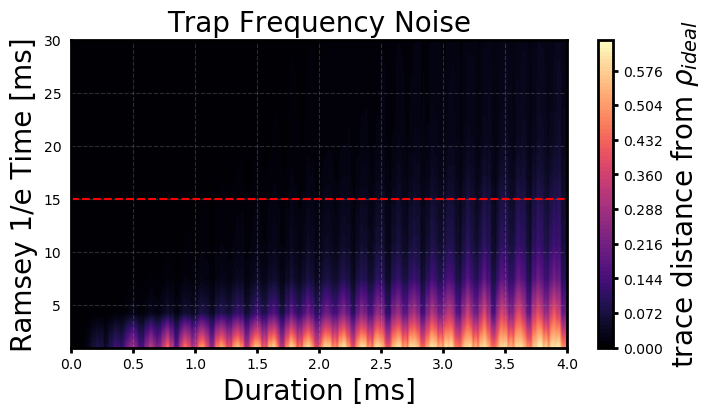

In [447]:
tspan = collect(0:1:4000)
plt.contourf(tspan .* 1e-3, rnus, reduce(hcat, Avg_sol3_fidnu)', fill=true, cmap="magma", levels=100)
plt.axhline(y=15, color="red", ls="--")
plt.colorbar(label=L"trace distance from $ρ_{ideal}$")
plt.xlim(tspan[1] * 1e-3, tspan[end] * 1e-3)
plt.xlabel("Duration [ms]")
plt.ylabel("Ramsey 1/e Time [ms]")
plt.title("Trap Frequency Noise")
plt.show()

In [441]:
nu = 5
N = 250
tspan = collect(0:2:20000)
sol3 = 0
for i in 1:N
    δν = √2 / (2π * nu * 1e-3)
    h3 = siv_three_lasers(δν=δν)
    sol3 ≡ 0 ? sol3 = dm.(rotated_solve(tspan, h3)) : sol3 .+= dm.(rotated_solve(tspan, h3))
end

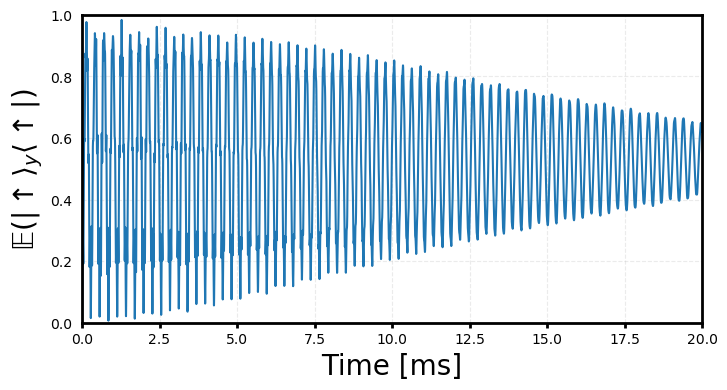

(0, 20)

In [442]:
plt.plot(tspan .* 1e-3, expect(dm(C["S-1/2"]) ⊗ one(com.basis), sol3 ./ N))
ideal = expect(dm(C["S-1/2"]) ⊗ one(com.basis), sol3_ideal)
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlabel("Time [ms]")
plt.ylim(0, 1)
plt.xlim(tspan[1] * 1e-3, tspan[end] * 1e-3)
plt.xlim(0, 20)

# Motional Heating

In [635]:
tspan = collect(0:1:4000)
Avg_sol3_fidhr = []
heating_rates = range(0, stop=1000, length=200)
for hr in heating_rates
    h3 = siv_three_lasers(N=Int(maximum([5, ceil(hr * timescale *  tspan[end] * 4)])))
    sol3 = rotated_solve(tspan, h3, heating_rate=hr)
    sol3_ideal = rotated_solve(tspan, h3)
    push!(Avg_sol3_fidhr, tracedistance.(sol3, dm.(sol3_ideal)))
end

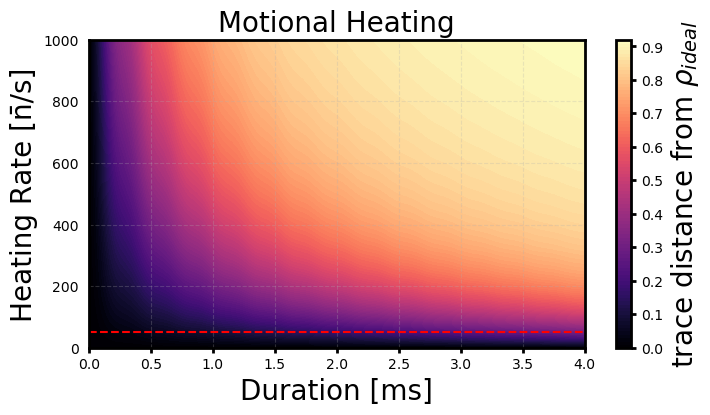

In [638]:
tspan = collect(0:1:4000)
plt.contourf(tspan .* 1e-3, heating_rates, reduce(hcat, Avg_sol3_fidhr)', fill=true, cmap="magma", levels=100)
plt.axhline(y=50, color="red", ls="--")
plt.colorbar(label=L"trace distance from $ρ_{ideal}$")
plt.xlim(tspan[1] * 1e-3, tspan[end] * 1e-3)
plt.xlabel("Duration [ms]")
plt.ylabel("Heating Rate [n̄/s]")
plt.title("Motional Heating")
plt.show()

In [647]:
tspan = collect(0:1:4000)
h3_nvd = siv_three_lasers(Δ=0, κ=0)
h3_nv = siv_three_lasers(κ=0)
h3 = siv_three_lasers()
hr = 50
sol3_nvd = rotated_solve(tspan, h3_nvd, fout=fout, heating_rate=hr)
sol3_nv = rotated_solve(tspan, h3_nv, fout=fout, heating_rate=hr)
sol3 = rotated_solve(tspan, h3, fout=fout, heating_rate=hr);

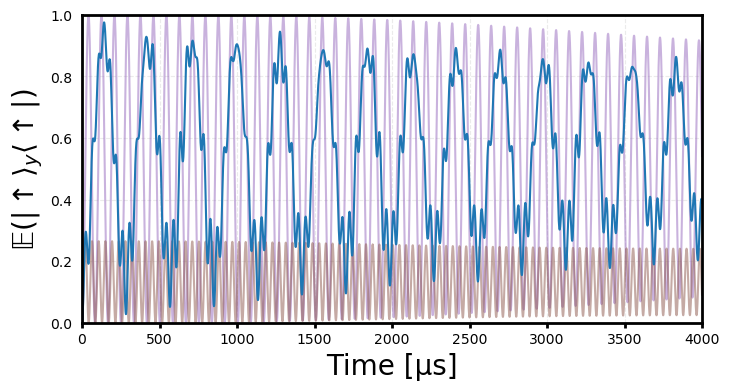

In [648]:
plt.plot(tspan, map(x->x[1], sol3_nvd), color="C4", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3_nv), color="C5", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3), color="C0")
plt.ylim(0, 1)
plt.xlabel("Time [μs]")
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlim(tspan[1], tspan[end])
# plt.legend(loc=1)
# plt.title("Ideal")
plt.show()

# Phase Noise

In [843]:
sb = SpinBasis(1//2)
function R(θ, ϕ)
    nx = sqrt(1 / (tan(ϕ)^2 + 1)) * sign(cos(ϕ))
    ny = (1 - nx^2) * sign(sin(ϕ))
    Rx2 = (
            DenseOperator(sb, [cos(θ/2) 0; 0 cos(θ/2)]) +
            nx * DenseOperator(sb, [0 -im*sin(θ/2); -im*sin(θ/2) 0]) +
            ny * DenseOperator(sb, [0 -sin(θ/2); sin(θ/2) 0])
        )
end

phase(ξ) = DenseOperator(sb, [1 0 ; 0 exp(im * ξ)])

θ = π/2
ϕ = π
freq = 5
N = 5000
tlist = 0:0.005:10
γ = 0.1
res = []
for t in tlist
    res_d = []
    for _ in 1:N
        psi = R(θ, 2π * γ * √t * randn() + π) * phase(2π * freq * t) * R(θ, 0) * spindown(sb)
        up = expect(dm(spinup(sb)), psi)
        down = expect(dm(spindown(sb)), psi)
        push!(res_d, up / (up + down))
    end
    push!(res, sum(res_d) / N)
end

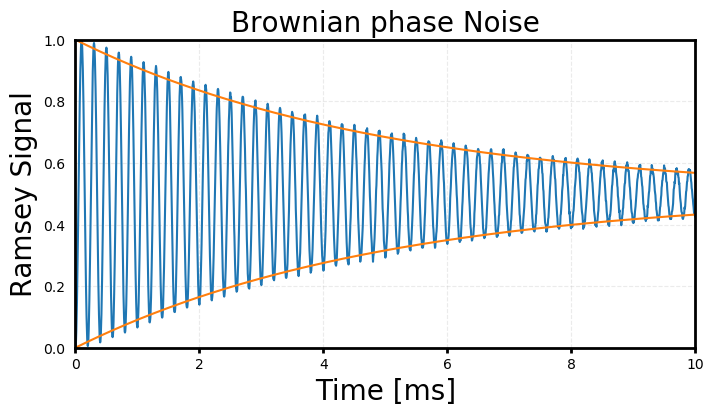

PyObject Text(0.5, 1.0, 'Brownian phase Noise')

In [857]:
plt.plot(tlist, res)
plt.plot(tlist, exp_decay.(tlist, 0.1*2), color="C1")
plt.plot(tlist, 1 .- exp_decay.(tlist, 0.1*2), color="C1")
plt.xlim(tlist[1], tlist[end])
plt.ylim(0, 1)
# plt.xlim(0, 1)
plt.xlabel("Time [ms]")
plt.ylabel("Ramsey Signal")
plt.title("Brownian phase Noise")

In [845]:
θ = π/2
ϕ = π
freq = 5
N = 5000
tlist = 0:0.005:10
γ = 0.1
res2 = []
for t in tlist
    res_d = []
    for _ in 1:N
        psi = R(θ, 2π * γ * t * randn() + π) * phase(2π * freq * t) * R(θ, 0) * spindown(sb)
        up = expect(dm(spinup(sb)), psi)
        down = expect(dm(spindown(sb)), psi)
        push!(res_d, up / (up + down))
    end
    push!(res2, sum(res_d) / N)
end

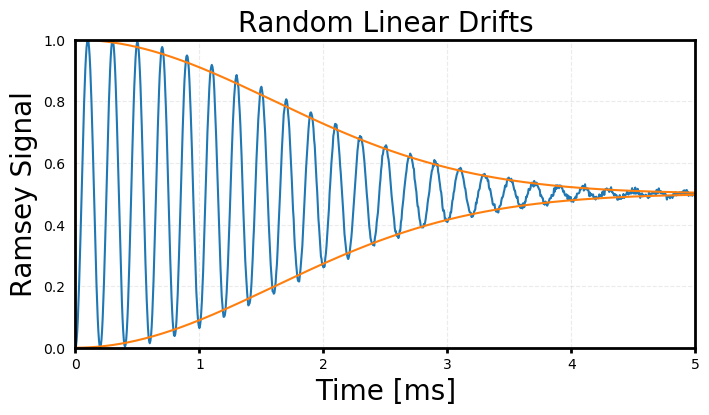

PyObject Text(0.5, 1.0, 'Random Linear Drifts')

In [860]:
plt.plot(tlist, res2)
plt.plot(tlist, gaussian_decay.(tlist, 2π*0.1), color="C1")
plt.plot(tlist, 1 .- gaussian_decay.(tlist, 2π*0.1), color="C1")
plt.xlim(tlist[1], tlist[end])
plt.xlim(0, 5)
plt.ylim(0, 1)
plt.xlabel("Time [ms]")
plt.ylabel("Ramsey Signal")
plt.title("Random Linear Drifts")

In [971]:
tspan = collect(0:1:4000)
pd = 100
sol3_nvd = zeros(Float64, length(tspan))
sol3_nv = zeros(Float64, length(tspan))
sol3 = zeros(Float64, length(tspan))
sol4 = zeros(Float64, length(tspan))
N = 500
for i in 1:N
    h3_nvd, f1 = siv_three_lasers(Δ=0, κ=0, phase_drift=pd)
    h3_nv, f2 = siv_three_lasers(κ=0, phase_drift=pd)
    h3, f3 = siv_three_lasers(phase_drift=pd)
    h4, f4 = siv_four_lasers(phase_drift=pd);
    sol3_nvd .+= rotated_solve(tspan, h3_nvd, fout=fouti, ξ=map(t->f1(t * 1e-6), tspan)) / N
    sol3_nv .+= rotated_solve(tspan, h3_nv, fout=fouti, ξ=map(t->f2(t * 1e-6), tspan)) / N
    sol3 .+= rotated_solve(tspan, h3, fout=fouti, ξ=map(t->f3(t * 1e-6), tspan)) / N
    sol4 .+= rotated_solve(tspan, h4, fout=fouti, ξ=map(t->f4(t * 1e-6), tspan)) / N
end

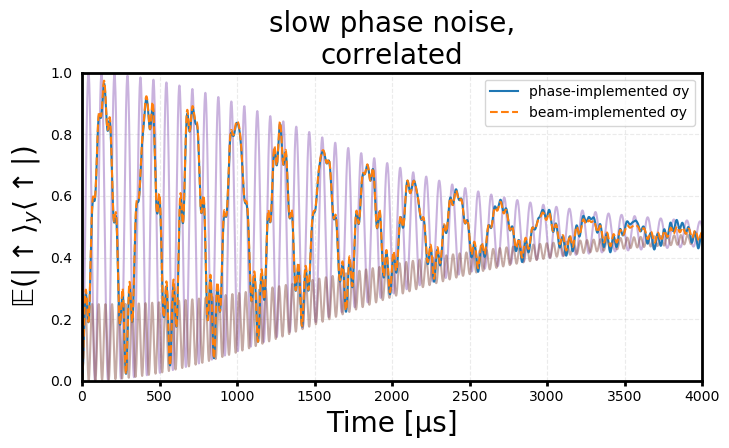

In [972]:
plt.plot(tspan, map(x->x[1], sol3_nvd), color="C4", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3_nv), color="C5", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3), label="phase-implemented σy", color="C0")
plt.plot(tspan, map(x->x[1], sol4), ls="--", label="beam-implemented σy", color="C1")
plt.ylim(0, 1)
plt.xlabel("Time [μs]")
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlim(tspan[1], tspan[end ÷ 1])
plt.legend(loc=1)
plt.title("slow phase noise,\ncorrelated")
plt.show()

In [973]:
tspan = collect(0:1:4000)
pd = 100
sol3_nvd = zeros(Float64, length(tspan))
sol3_nv = zeros(Float64, length(tspan))
sol3 = zeros(Float64, length(tspan))
sol4 = zeros(Float64, length(tspan))
N = 500
for i in 1:N
    h3_nvd, f1 = siv_three_lasers(Δ=0, κ=0, phase_drift=pd)
    h3_nv, f2 = siv_three_lasers(κ=0, phase_drift=pd)
    h3, f3 = siv_three_lasers(phase_drift=pd)
    h4, f4 = siv_four_lasers(phase_drift=pd);
    sol3_nvd .+= rotated_solve(tspan, h3_nvd, fout=fouti) / N
    sol3_nv .+= rotated_solve(tspan, h3_nv, fout=fouti) / N
    sol3 .+= rotated_solve(tspan, h3, fout=fouti) / N
    sol4 .+= rotated_solve(tspan, h4, fout=fouti) / N
end

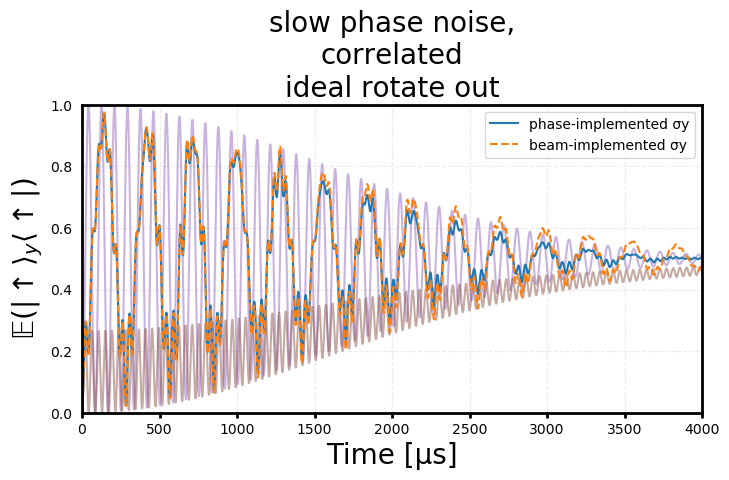

In [974]:
plt.plot(tspan, map(x->x[1], sol3_nvd), color="C4", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3_nv), color="C5", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3), label="phase-implemented σy", color="C0")
plt.plot(tspan, map(x->x[1], sol4), ls="--", label="beam-implemented σy", color="C1")
plt.ylim(0, 1)
plt.xlabel("Time [μs]")
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlim(tspan[1], tspan[end ÷ 1])
plt.legend(loc=1)
plt.title("slow phase noise,\ncorrelated\nideal rotate out")
plt.show()

In [975]:
tspan = collect(0:1:4000)
pd = 100
sol3_nvd = zeros(Float64, length(tspan))
sol3_nv = zeros(Float64, length(tspan))
sol3 = zeros(Float64, length(tspan))
sol4 = zeros(Float64, length(tspan))
N = 500
for i in 1:N
    h3_nvd, f1 = siv_three_lasers(Δ=0, κ=0, phase_drift=pd, correlated_phase_drift=false)
    h3_nv, f2 = siv_three_lasers(κ=0, phase_drift=pd, correlated_phase_drift=false)
    h3, f3 = siv_three_lasers(phase_drift=pd, correlated_phase_drift=false)
    h4, f4 = siv_four_lasers(phase_drift=pd, correlated_phase_drift=false);
    sol3_nvd .+= rotated_solve(tspan, h3_nvd, fout=fouti, ξ=map(t->f1(t * 1e-6), tspan)) / N
    sol3_nv .+= rotated_solve(tspan, h3_nv, fout=fouti, ξ=map(t->f2(t * 1e-6), tspan)) / N
    sol3 .+= rotated_solve(tspan, h3, fout=fouti, ξ=map(t->f3(t * 1e-6), tspan)) / N
    sol4 .+= rotated_solve(tspan, h4, fout=fouti, ξ=map(t->f4(t * 1e-6), tspan)) / N
end

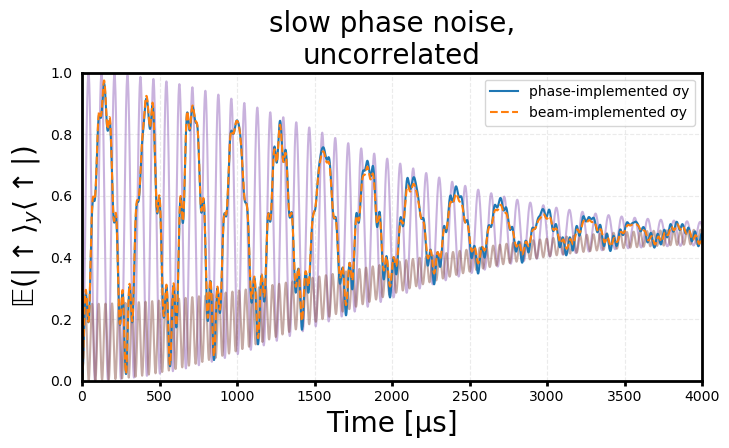

In [976]:
plt.plot(tspan, map(x->x[1], sol3_nvd), color="C4", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3_nv), color="C5", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3), label="phase-implemented σy", color="C0")
plt.plot(tspan, map(x->x[1], sol4), ls="--", label="beam-implemented σy", color="C1")
plt.ylim(0, 1)
plt.xlabel("Time [μs]")
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlim(tspan[1], tspan[end ÷ 1])
plt.legend(loc=1)
plt.title("slow phase noise,\nuncorrelated")
plt.show()

In [977]:
tspan = collect(0:1:4000)
pd = 100
sol3_nvd = zeros(Float64, length(tspan))
sol3_nv = zeros(Float64, length(tspan))
sol3 = zeros(Float64, length(tspan))
sol4 = zeros(Float64, length(tspan))
N = 500
for i in 1:N
    h3_nvd, f1 = siv_three_lasers(Δ=0, κ=0, phase_drift=pd, correlated_phase_drift=false)
    h3_nv, f2 = siv_three_lasers(κ=0, phase_drift=pd, correlated_phase_drift=false)
    h3, f3 = siv_three_lasers(phase_drift=pd, correlated_phase_drift=false)
    h4, f4 = siv_four_lasers(phase_drift=pd, correlated_phase_drift=false);
    sol3_nvd .+= rotated_solve(tspan, h3_nvd, fout=fouti) / N
    sol3_nv .+= rotated_solve(tspan, h3_nv, fout=fouti) / N
    sol3 .+= rotated_solve(tspan, h3, fout=fouti) / N
    sol4 .+= rotated_solve(tspan, h4, fout=fouti) / N
end

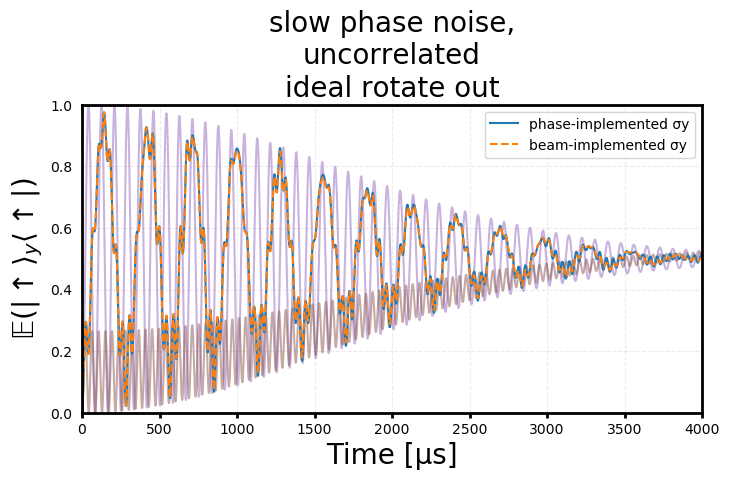

In [978]:
plt.plot(tspan, map(x->x[1], sol3_nvd), color="C4", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3_nv), color="C5", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3), label="phase-implemented σy", color="C0")
plt.plot(tspan, map(x->x[1], sol4), ls="--", label="beam-implemented σy", color="C1")
plt.ylim(0, 1)
plt.xlabel("Time [μs]")
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlim(tspan[1], tspan[end ÷ 1])
plt.legend(loc=1)
plt.title("slow phase noise,\nuncorrelated\nideal rotate out")
plt.show()

In [16]:
tspan = collect(0:1:4000)
Avg_sol3_fidph = []
N = 250
pds = range(1, stop=500, length=50)
for pd in pds
    for i in 1:N
        h3, f = siv_three_lasers(phase_drift=pd)
        if i == 1
            sol3 = dm.(rotated_solve(tspan, h3, ξ=map(t->f(t * 1e-6), tspan)))
        else
            sol3 .+= dm.(rotated_solve(tspan, h3, ξ=map(t->f(t * 1e-6), tspan)))
        end
    end
    push!(Avg_sol3_fidph, tracedistance.(sol3 ./ N, dm_sol3_ideal))
end

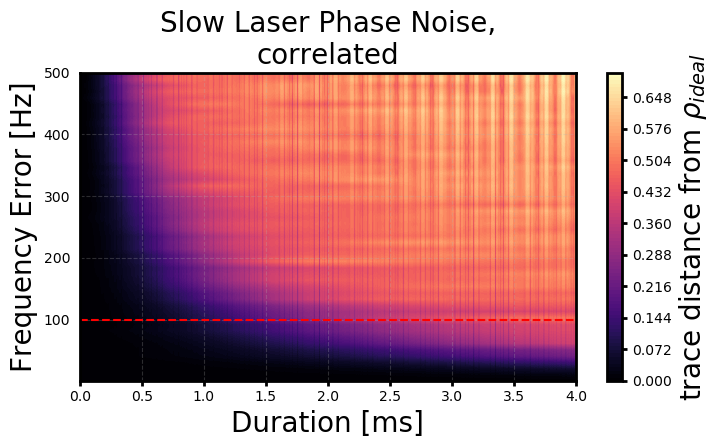

In [18]:
tspan = collect(0:1:4000)
plt.contourf(tspan .* 1e-3, pds, reduce(hcat, Avg_sol3_fidph)', fill=true, cmap="magma", levels=100)
plt.axhline(y=100, color="red", ls="--")
plt.colorbar(label=L"trace distance from $ρ_{ideal}$")
plt.xlim(tspan[1] * 1e-3, tspan[end] * 1e-3)
plt.xlabel("Duration [ms]")
plt.ylabel("Frequency Error [Hz]")
plt.title("Slow Laser Phase Noise,\ncorrelated")
plt.show()

In [13]:
tspan = collect(0:1:4000)
Avg_sol3_fidph = []
N = 250
pds = range(1, stop=500, length=50)
for pd in pds
    for i in 1:N
        h3, f = siv_three_lasers(phase_drift=pd, correlated_phase_drift=false)
        if i == 1
            sol3 = dm.(rotated_solve(tspan, h3, ξ=map(t->f(t * 1e-6), tspan)))
        else
            sol3 .+= dm.(rotated_solve(tspan, h3, ξ=map(t->f(t * 1e-6), tspan)))
        end
    end
    push!(Avg_sol3_fidph, tracedistance.(sol3 ./ N, dm_sol3_ideal))
end

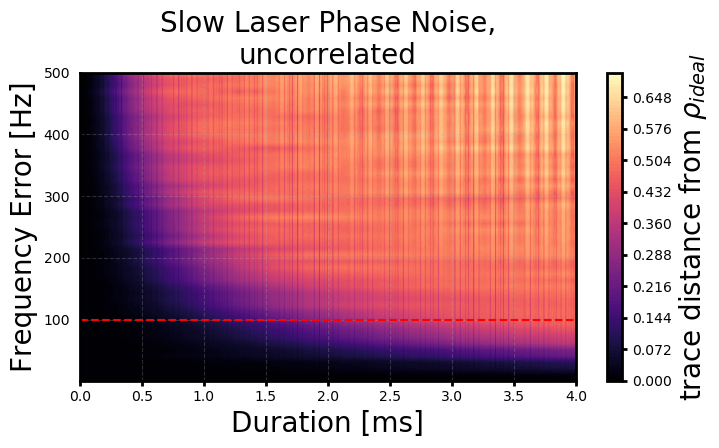

In [15]:
tspan = collect(0:1:4000)
plt.contourf(tspan .* 1e-3, pds, reduce(hcat, Avg_sol3_fidph)', fill=true, cmap="magma", levels=100)
plt.axhline(y=100, color="red", ls="--")
plt.colorbar(label=L"trace distance from $ρ_{ideal}$")
plt.xlim(tspan[1] * 1e-3, tspan[end] * 1e-3)
plt.xlabel("Duration [ms]")
plt.ylabel("Frequency Error [Hz]")
plt.title("Slow Laser Phase Noise,\nuncorrelated")
plt.show()

# Combined Noise

In [58]:
tspan = collect(0:1:4000)
sol3_nvd = zeros(ComplexF64, length(tspan))
sol3_nv = zeros(ComplexF64, length(tspan))
sol3 = zeros(ComplexF64, length(tspan))
sol4 = zeros(ComplexF64, length(tspan))
N = 500
for i in 1:N
    # bfield
    δB = √2 / (dB * 20e-3)
    ddb = δB * randn()
    # intensity
    δJ = 0.01 / 2 
    # trap frequency
    δν = √2 / (2π * 5 * 1e-3)
    # motional heating
    hr = 50
    # phase noise
    pd = 100
    h3_nvd, f1 = siv_three_lasers(Δ=0, κ=0, phase_drift=pd, δB=ddb, δJ=δJ, δν=δν)
    h3_nv, f2 = siv_three_lasers(κ=0, phase_drift=pd, δB=ddb, δJ=δJ, δν=δν)
    h3, f3 = siv_three_lasers(phase_drift=pd, δB=ddb, δJ=δJ, δν=δν)
    h4, f4 = siv_four_lasers(phase_drift=pd, δB=ddb, δJ=δJ, δν=δν);
    sol3_nvd .+= rotated_solve(tspan, h3_nvd, fout=fouti, heating_rate=hr, ξ=map(t->f1(t * 1e-6), tspan)) / N
    sol3_nv .+= rotated_solve(tspan, h3_nv, fout=fouti, heating_rate=hr, ξ=map(t->f2(t * 1e-6), tspan)) / N
    sol3 .+= rotated_solve(tspan, h3, fout=fouti, heating_rate=hr, ξ=map(t->f3(t * 1e-6), tspan)) / N
    sol4 .+= rotated_solve(tspan, h4, fout=fouti, heating_rate=hr, ξ=map(t->f4(t * 1e-6), tspan)) / N
end

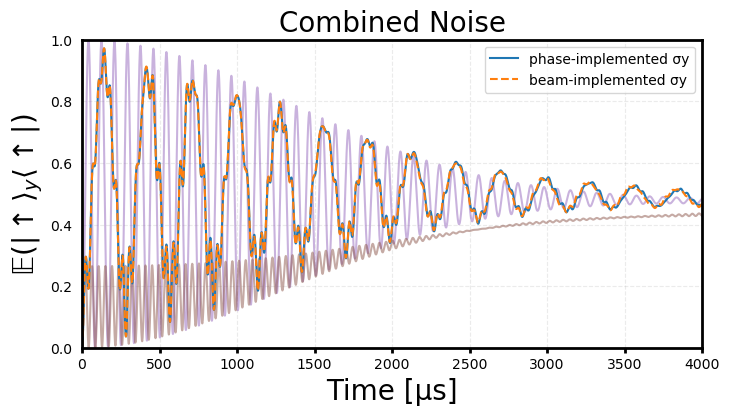

In [60]:
plt.plot(tspan, map(x->x[1], sol3_nvd), color="C4", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3_nv), color="C5", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3), label="phase-implemented σy", color="C0")
plt.plot(tspan, map(x->x[1], sol4), ls="--", label="beam-implemented σy", color="C1")
plt.ylim(0, 1)
plt.xlabel("Time [μs]")
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlim(tspan[1], tspan[end ÷ 1])
plt.legend(loc=1)
plt.title("Combined Noise")
plt.show()

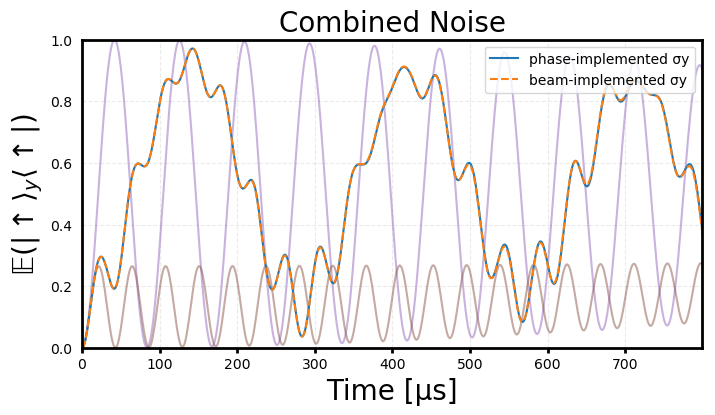

In [62]:
plt.plot(tspan, map(x->x[1], sol3_nvd), color="C4", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3_nv), color="C5", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3), label="phase-implemented σy", color="C0")
plt.plot(tspan, map(x->x[1], sol4), ls="--", label="beam-implemented σy", color="C1")
plt.ylim(0, 1)
plt.xlabel("Time [μs]")
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlim(tspan[1], tspan[end ÷ 5])
plt.legend(loc=1)
plt.title("Combined Noise")
plt.show()

# Matching Data

In [63]:
# Phase Implmented detuning data
ydata = h5read("/Users/joe/Desktop/2020-03-16/SingleIonVAET/1514_49.h5", "scan_data/SingleIonVAET-dark_ions:0")
xdata = h5read("/Users/joe/Desktop/2020-03-16/SingleIonVAET/1514_49.h5", "scan_data/SingleIonVAET.duration")
ydata1 = h5read("/Users/joe/Desktop/2020-03-16/SingleIonVAET/1601_48.h5", "scan_data/SingleIonVAET-dark_ions:0")
xdata1 = h5read("/Users/joe/Desktop/2020-03-16/SingleIonVAET/1601_48.h5", "scan_data/SingleIonVAET.duration")
ydata2 = h5read("/Users/joe/Desktop/2020-03-16/SingleIonVAET/1612_29.h5", "scan_data/SingleIonVAET-dark_ions:0")
xdata2 = h5read("/Users/joe/Desktop/2020-03-16/SingleIonVAET/1612_29.h5", "scan_data/SingleIonVAET.duration")
;

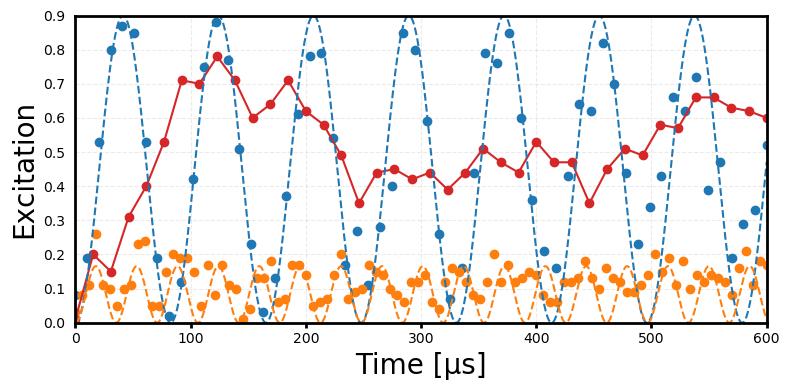

In [64]:
plt.plot(xdata ./ 1e-6, ydata, lw=0, marker="o", color="C0")
plt.plot(xdata1 ./ 1e-6, ydata1, lw=0, marker="o", color="C1")
plt.plot(xdata2 ./ 1e-6, ydata2, color="C3", marker="o")
xd = 0:0.01:600
plt.plot(xd, @.(0.9 * sin(0.038 * xd)^2), color="C0", ls="--")
delta = 0.08
plt.plot(xd, @.(0.9 * (0.038^2 / (0.038^2 + delta^2)) * sin(sqrt(0.038^2 + delta^2) * xd)^2), color="C1", ls="--")
plt.xlim(0, 600)
plt.ylim(0, 0.9)
plt.xlabel("Time [μs]")
plt.ylabel("Excitation")
plt.tight_layout()
plt.savefig("/Users/joe/Desktop/temp_images/method1.png")
plt.show()

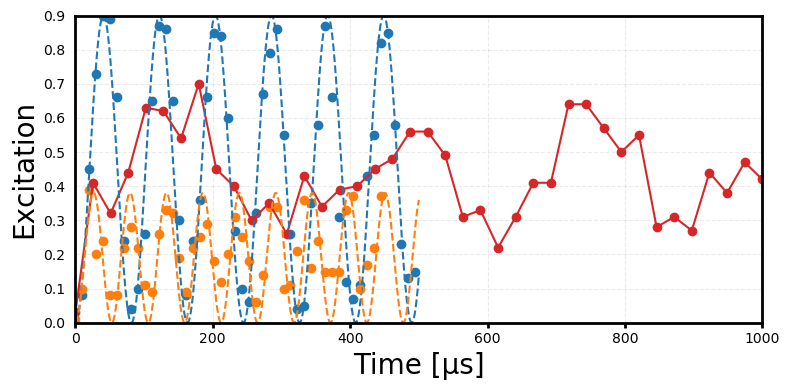

In [65]:
# beam implemented detuning data
ydata = h5read("/Users/joe/Desktop/2020-03-16/SingleIonVAET/1805_27.h5", "scan_data/SingleIonVAET-dark_ions:0")
xdata = h5read("/Users/joe/Desktop/2020-03-16/SingleIonVAET/1805_27.h5", "scan_data/SingleIonVAET.duration")
ydata1 = h5read("/Users/joe/Desktop/2020-03-16/SingleIonVAET/1812_21.h5", "scan_data/SingleIonVAET-dark_ions:0")
xdata1 = h5read("/Users/joe/Desktop/2020-03-16/SingleIonVAET/1812_21.h5", "scan_data/SingleIonVAET.duration")
ydata2 = h5read("/Users/joe/Desktop/2020-03-16/SingleIonVAET/1831_39.h5", "scan_data/SingleIonVAET-dark_ions:0")
xdata2 = h5read("/Users/joe/Desktop/2020-03-16/SingleIonVAET/1831_39.h5", "scan_data/SingleIonVAET.duration")

plt.plot(xdata ./ 1e-6, ydata, lw=0, marker="o", color="C0")
plt.plot(xdata1 ./ 1e-6, ydata1, lw=0, marker="o", color="C1")
plt.plot(xdata2 ./ 1e-6, ydata2, marker="o", color="C3")
xd = 0:0.01:500
plt.plot(xd, @.(0.9 * sin(0.0385 * xd)^2), color="C0", ls="--")
delta = 0.045
plt.plot(xd, @.(0.9 * (0.0385^2 / (0.0385^2 + delta^2)) * sin(sqrt(0.0385^2 + delta^2) * xd)^2), color="C1", ls="--")
plt.xlim(0, 1000)
plt.ylim(0, 0.9)
plt.xlabel("Time [μs]")
plt.ylabel("Excitation")
plt.tight_layout()
plt.savefig("/Users/joe/Desktop/temp_images/method2.png")
plt.show()

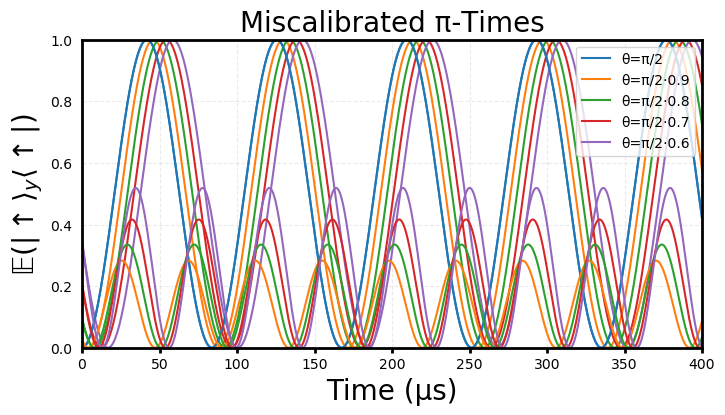

In [77]:
h3_nvd = siv_three_lasers(Δ=0, κ=0)
h3_nv = siv_three_lasers(κ=0)
tspan = collect(0:0.1:400)
sol3_nvd = rotated_solve(tspan, h3_nvd, fout=fout)
sol3_nvd1 = rotated_solve(tspan, h3_nvd, fout=fout, θ=π/2 * 0.9)
sol3_nvd2 = rotated_solve(tspan, h3_nvd, fout=fout, θ=π/2 * 0.8)
sol3_nvd3 = rotated_solve(tspan, h3_nvd, fout=fout, θ=π/2 * 0.7)
sol3_nvd4 = rotated_solve(tspan, h3_nvd, fout=fout, θ=π/2 * 0.6)
sol3_nv = rotated_solve(tspan, h3_nvd, fout=fout)
sol3_nv1 = rotated_solve(tspan, h3_nv, fout=fout, θ=π/2 * 0.9)
sol3_nv2 = rotated_solve(tspan, h3_nv, fout=fout, θ=π/2 * 0.8)
sol3_nv3 = rotated_solve(tspan, h3_nv, fout=fout, θ=π/2 * 0.7)
sol3_nv4 = rotated_solve(tspan, h3_nv, fout=fout, θ=π/2 * 0.6)
plt.plot(tspan, map(x->x[1], sol3_nvd), label="θ=π/2")
plt.plot(tspan, map(x->x[1], sol3_nvd1), label="θ=π/2⋅0.9")
plt.plot(tspan, map(x->x[1], sol3_nvd2), label="θ=π/2⋅0.8")
plt.plot(tspan, map(x->x[1], sol3_nvd3), label="θ=π/2⋅0.7")
plt.plot(tspan, map(x->x[1], sol3_nvd4), label="θ=π/2⋅0.6")
plt.plot(tspan, map(x->x[1], sol3_nv), color="C0")
plt.plot(tspan, map(x->x[1], sol3_nv1), color="C1")
plt.plot(tspan, map(x->x[1], sol3_nv2), color="C2")
plt.plot(tspan, map(x->x[1], sol3_nv3), color="C3")
plt.plot(tspan, map(x->x[1], sol3_nv4), color="C4")
plt.ylim(0, 1)
plt.xlabel("Time (μs)")
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlim(tspan[1], tspan[end ÷ 1])
plt.legend(loc=1)
plt.title("Miscalibrated π-Times")
plt.show()

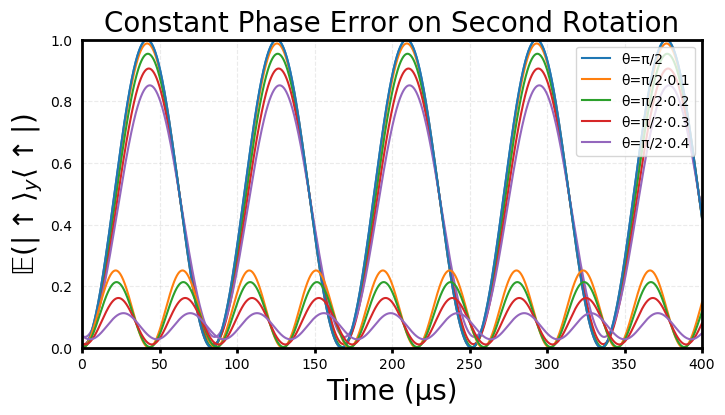

In [80]:
h3_nvd = siv_three_lasers(Δ=0, κ=0)
h3_nv = siv_three_lasers(κ=0)
tspan = collect(0:0.1:400)
sol3_nvd = rotated_solve(tspan, h3_nvd, fout=fout)
sol3_nvd1 = rotated_solve(tspan, h3_nvd, fout=fout, ξ=π/2 * 0.1)
sol3_nvd2 = rotated_solve(tspan, h3_nvd, fout=fout, ξ=π/2 * 0.2)
sol3_nvd3 = rotated_solve(tspan, h3_nvd, fout=fout, ξ=π/2 * 0.3)
sol3_nvd4 = rotated_solve(tspan, h3_nvd, fout=fout, ξ=π/2 * 0.4)
sol3_nv = rotated_solve(tspan, h3_nvd, fout=fout)
sol3_nv1 = rotated_solve(tspan, h3_nv, fout=fout, ξ=π/2 * 0.1)
sol3_nv2 = rotated_solve(tspan, h3_nv, fout=fout, ξ=π/2 * 0.2)
sol3_nv3 = rotated_solve(tspan, h3_nv, fout=fout, ξ=π/2 * 0.3)
sol3_nv4 = rotated_solve(tspan, h3_nv, fout=fout, ξ=π/2 * 0.4)
plt.plot(tspan, map(x->x[1], sol3_nvd), label="θ=π/2")
plt.plot(tspan, map(x->x[1], sol3_nvd1), label="θ=π/2⋅0.1")
plt.plot(tspan, map(x->x[1], sol3_nvd2), label="θ=π/2⋅0.2")
plt.plot(tspan, map(x->x[1], sol3_nvd3), label="θ=π/2⋅0.3")
plt.plot(tspan, map(x->x[1], sol3_nvd4), label="θ=π/2⋅0.4")
plt.plot(tspan, map(x->x[1], sol3_nv), color="C0")
plt.plot(tspan, map(x->x[1], sol3_nv1), color="C1")
plt.plot(tspan, map(x->x[1], sol3_nv2), color="C2")
plt.plot(tspan, map(x->x[1], sol3_nv3), color="C3")
plt.plot(tspan, map(x->x[1], sol3_nv4), color="C4")
plt.ylim(0, 1)
plt.xlabel("Time (μs)")
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlim(tspan[1], tspan[end ÷ 1])
plt.legend(loc=1)
plt.title("Constant Phase Error on Second Rotation")
plt.show()

In [81]:
tspan = collect(0:1:4000)
sol3_nvd = zeros(ComplexF64, length(tspan))
sol3_nv = zeros(ComplexF64, length(tspan))
sol3 = zeros(ComplexF64, length(tspan))
sol4 = zeros(ComplexF64, length(tspan))
N = 500
for i in 1:N
    # bfield
    δB = √2 / (dB * 20e-3)
    ddb = δB * randn()
    # intensity
    δJ = 0.01 / 2 
    # trap frequency
    δν = √2 / (2π * 5 * 1e-3)
    # motional heating
    hr = 50
    # phase noise
    pd = 100
    h3_nvd, f1 = siv_three_lasers(Δ=0, κ=0, phase_drift=pd, δB=ddb, δJ=δJ, δν=δν)
    h3_nv, f2 = siv_three_lasers(κ=0, phase_drift=pd, δB=ddb, δJ=δJ, δν=δν)
    h3, f3 = siv_three_lasers(phase_drift=pd, δB=ddb, δJ=δJ, δν=δν)
    h4, f4 = siv_four_lasers(phase_drift=pd, δB=ddb, δJ=δJ, δν=δν);
    sol3_nvd .+= rotated_solve(tspan, h3_nvd, fout=fouti, heating_rate=hr, ξ=π/2 * 0.3 .+ map(t->f1(t * 1e-6), tspan)) / N
    sol3_nv .+= rotated_solve(tspan, h3_nv, fout=fouti, heating_rate=hr, ξ=π/2 * 0.3 .+ map(t->f2(t * 1e-6), tspan)) / N
    sol3 .+= rotated_solve(tspan, h3, fout=fouti, heating_rate=hr, ξ=π/2 * 0.3 .+ map(t->f3(t * 1e-6), tspan)) / N
    sol4 .+= rotated_solve(tspan, h4, fout=fouti, heating_rate=hr, ξ=π/2 * 0.3 .+ map(t->f4(t * 1e-6), tspan)) / N
end

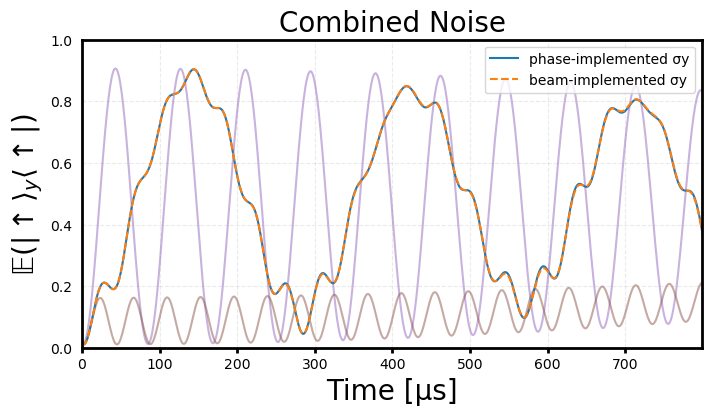

In [83]:
plt.plot(tspan, map(x->x[1], sol3_nvd), color="C4", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3_nv), color="C5", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3), label="phase-implemented σy", color="C0")
plt.plot(tspan, map(x->x[1], sol4), ls="--", label="beam-implemented σy", color="C1")
plt.ylim(0, 1)
plt.xlabel("Time [μs]")
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlim(tspan[1], tspan[end ÷ 5])
plt.legend(loc=1)
plt.title("Combined Noise")
plt.show()

In [92]:
tspan = collect(0:1:8000)
θ = π/2
sol3 = rotated_solve(tspan, h3, fout=fout, θ=θ, n̄=0)
sol31 = rotated_solve(tspan, h3, fout=fout, θ=θ, n̄=0.2)
sol32 = rotated_solve(tspan, h3, fout=fout, θ=θ, n̄=0.4)
sol33 = rotated_solve(tspan, h3, fout=fout, θ=θ, n̄=0.6)
sol34 = rotated_solve(tspan, h3, fout=fout, θ=θ, n̄=0.8)
sol35 = rotated_solve(tspan, h3, fout=fout, θ=θ, n̄=1)
sol36 = rotated_solve(tspan, h3, fout=fout, θ=θ, n̄=2);

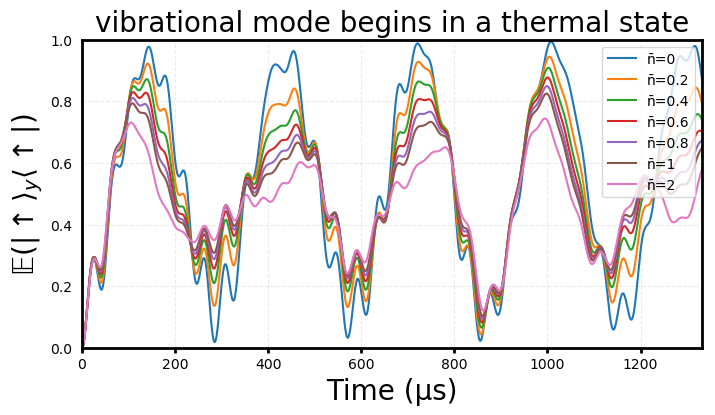

In [100]:
plt.plot(tspan, map(x->x[1], sol3), label="n̄=0")
plt.plot(tspan, map(x->x[1], sol31), label="n̄=0.2")
plt.plot(tspan, map(x->x[1], sol32), label="n̄=0.4")
plt.plot(tspan, map(x->x[1], sol33), label="n̄=0.6")
plt.plot(tspan, map(x->x[1], sol34), label="n̄=0.8")
plt.plot(tspan, map(x->x[1], sol35), label="n̄=1")
plt.plot(tspan, map(x->x[1], sol36), label="n̄=2")
plt.ylim(0, 1)
plt.xlabel("Time (μs)")
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.title("vibrational mode begins in a thermal state")
plt.xlim(tspan[1], tspan[end ÷ 6])
plt.legend(loc=1)
plt.show()

In [107]:
tspan = collect(0:1:600)
sol3_nvd = zeros(ComplexF64, length(tspan))
sol3_nv = zeros(ComplexF64, length(tspan))
sol3 = zeros(ComplexF64, length(tspan))
# sol4 = zeros(ComplexF64, length(tspan))
N = 500
for i in 1:N
    # bfield
    δB = √2 / (dB * 20e-3)
    ddb = δB * randn()
    # intensity
    δJ = 0.01 / 2 
    # trap frequency
    δν = √2 / (2π * 5 * 1e-3)
    # motional heating
    hr = 50
    # phase noise
    pd = 100
    # rotation error
    ξ = π/2 * 0.35
    # initial thermal occupation
    n̄ = 0.5
    h3_nvd, f1 = siv_three_lasers(Δ=0, κ=0, phase_drift=pd, δB=ddb, δJ=δJ, δν=δν)
    h3_nv, f2 = siv_three_lasers(κ=0, phase_drift=pd, δB=ddb, δJ=δJ, δν=δν)
    h3, f3 = siv_three_lasers(phase_drift=pd, δB=ddb, δJ=δJ, δν=δν)
#     h4, f4 = siv_four_lasers(phase_drift=pd, δB=ddb, δJ=δJ, δν=δν);
    sol3_nvd .+= rotated_solve(tspan, h3_nvd, n̄=n̄, fout=fouti, heating_rate=hr, ξ=ξ .+ map(t->f1(t * 1e-6), tspan)) / N
    sol3_nv .+= rotated_solve(tspan, h3_nv, n̄=n̄, fout=fouti, heating_rate=hr, ξ=ξ .+ map(t->f2(t * 1e-6), tspan)) / N
    sol3 .+= rotated_solve(tspan, h3, n̄=n̄, fout=fouti, heating_rate=hr, ξ=ξ .+ map(t->f3(t * 1e-6), tspan)) / N
#     sol4 .+= rotated_solve(tspan, h4, n̄=n̄, fout=fouti, heating_rate=hr, ξ=ξ .+ map(t->f4(t * 1e-6), tspan)) / N
end

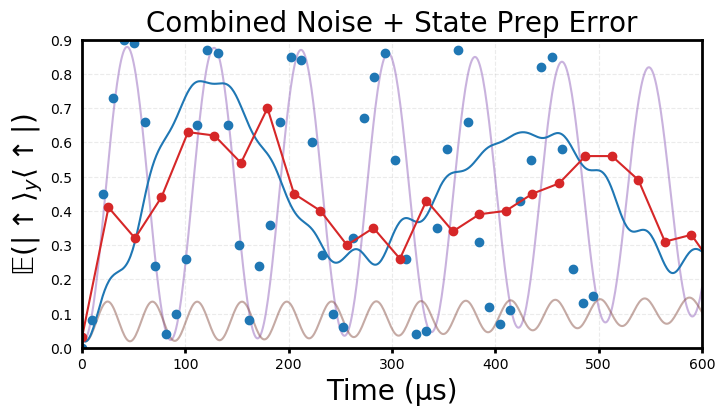

In [115]:
plt.plot(tspan, map(x->x[1], sol3_nvd), color="C4", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3_nv), color="C5", alpha=0.5)
plt.plot(tspan, map(x->x[1], sol3), color="C0")
plt.plot(xdata ./ 1e-6, ydata, lw=0, marker="o", color="C0")
plt.plot(xdata2 ./ 1e-6, ydata2, marker="o", color="C3")
plt.ylim(0, 0.9)
plt.xlabel("Time (μs)")
plt.ylabel(L"$𝔼(|\uparrow⟩_y\langle \uparrow |)$")
plt.xlim(tspan[1], tspan[end ÷ 1])
# plt.legend(loc=1)
plt.title("Combined Noise + State Prep Error")
plt.show()